In [1]:
import config
import matplotlib.pyplot as plt
from testing import *
import IFCAPOL as pol

%matplotlib inline

### Groups of unidentified sources

From the IFCAPOL_demo notebook (spring-summer 2022) we remind some numbers:

- Over the 100 `LB_LFT_40` simulations, we find 1108 $5\sigma$ unmatched sources with $|b|\geq5$ deg.
- But these 1108 objects correspond to only 32 unique coordinates. We have used a 30 arcmin search radius to form groups of detections. Each of these groups define what we call a unique coordinate.
- On average, each group has $\sim 32$ objects distributed across the 100 simulations. The largest group has 100 elements (that is, a unmatched source that appears in all the 100 `LB_LFT_40` simulations, and the smallest group has only 1 element (that is, a detection that appears in one simulation).

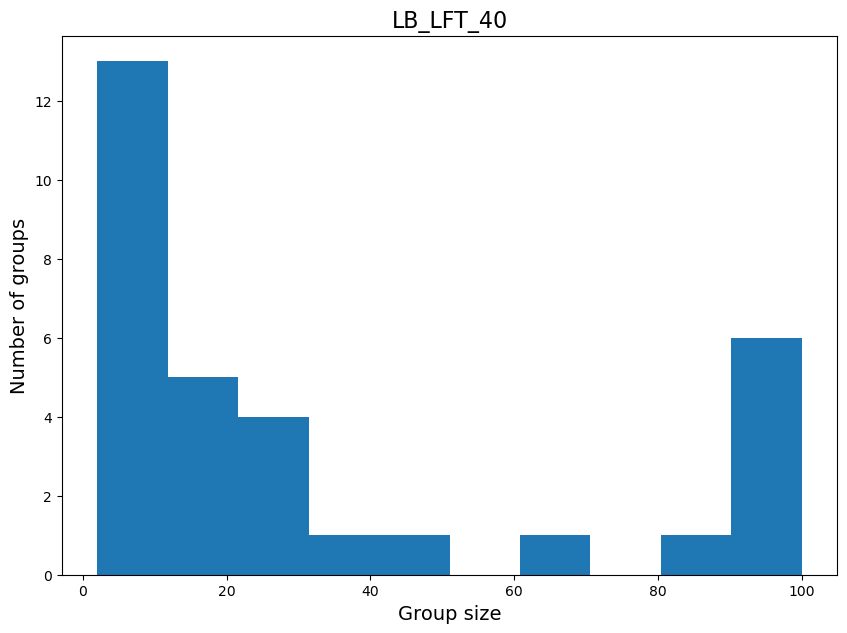

In [2]:
from astropy.table import Table,unique
catdir = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Catalogs/Output/'
fname  = catdir+'groups.fits'
groups = Table.read(fname)
groups = groups[groups['GroupID']>=1]
groups = unique(groups,keys=['GroupID'])
sizes  = groups['GroupSize']
from astropy.visualization import hist
plt.figure(figsize=(10,7))
hist(sizes,bins=10);
plt.xlabel('Group size',fontsize=14);
plt.ylabel('Number of groups',fontsize=14);
plt.title('LB_LFT_40',fontsize=16);

## Update: 27/09/2022

### Identification of unmatched sources

Identification of unmatched sources is a difficult and slow task. For the 32 candidates found at 40 GHz we run queries to NED, one at a time. Here are the main results:

In [3]:
from search_NED import find_type
from astroquery.simbad import Simbad

groups.sort('GroupSize')     
groups.reverse()                  # we sort the candidates by descending group size 
                                  # (sources that are in a higher number of simulations 
                                  #  are studied first)
        
coords = table2skycoord(groups)

_Planck_'s PCCS2 catalogue at 44 GHz:

In [4]:
# PCCS2 at 044 GHz may be useful:

from catalogue_tools import extract_nearest_object
PCCS244 = Table.read('/Users/herranz/Dropbox/Trabajo/Planck/Non_Thermal_Catalogue/Results/PCCS2/COM_PCCS_044_R2.04.fits')

Matching between the _Planck_ PCCS2 at 44 GHz and the groups of unmatched sources:

In [5]:
from catalogue_tools import cat_match

radio = 30*u.arcmin

inplanck = cat_match(groups,PCCS244,radio)

print(' {0} groups have a counterpart within {1} arcmin to the PCCS2 at 40 GHz'.format(len(inplanck),radio.value))

 19 groups have a counterpart within 30.0 arcmin to the PCCS2 at 40 GHz


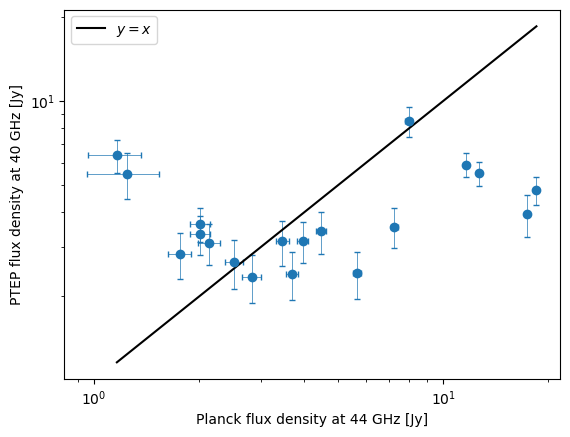

In [6]:
from linfit_errorsxy import linfit_errxy,plotfit

x  = inplanck['DETFLUX']/1000
ex = inplanck['DETFLUX_ERR']/1000
y  = inplanck['I [Jy]']
ey = inplanck['I err [Jy]'] 

o1,o2 = linfit_errxy(x,y,ex,ey);
plotfit(x,y,ex,ey,o2,logscal=True,
        x_label='Planck flux density at 44 GHz [Jy]',
        y_label='PTEP flux density at 40 GHz [Jy]',
        addfit=False);

z = np.linspace(x.min(),x.max(),1000)
plt.plot(z,z,'k',label=r'$y=x$');
plt.legend();

Bright sources tend to be underestimated while faint sources tend to be overestimated.

Routines for individual study of sources:

In [7]:
import astropy.units as u

def check_source(number,radius=10*u.arcmin,query_databases=True):
    
    c = coords[number]
    input_source   = pol.Source.from_coordinate(radiops,c)
    IFCAPOL_source = pol.Source.from_coordinate(total,c)
    input_source.draw()
    IFCAPOL_source.draw()

    print(' ')
    print('Source {0} detected with IFCAPOL at 40 GHz with S = {1} \pm {2} Jy'.format(number+1,groups['I [Jy]'][number], groups['I err [Jy]'][number]))
    print(' ')
    print('Galactic coordinates =',c.galactic)
    
    if query_databases:
        lQSO = find_type(c,radius,'QSO')
        lRad = find_type(c,radius,'RadioS')
    else:
        lQSO = []
        lRad = []
    
    planck = extract_nearest_object(PCCS244,c)
    d      = planck['Separation'].to(u.arcmin)[0].value
    name   = planck['NAME'][0]
    S      = planck['DETFLUX'][0]/1000
    eS     = planck['DETFLUX_ERR'][0]/1000
    
    print(' ')
    print(' Nearest PCCS2044 source is {0}, located at {1} arcmin of this position, with flux density = {2} \pm {3} Jy'.format(name,d,S,eS))
    print(' ')
    
    return {'QSO_assoc':lQSO,'RadioS_assoc':lRad,'radiops_patch':input_source,'total_patch':IFCAPOL_source,'planck_source':planck}

### Source number 1

In [8]:
%matplotlib inline

number    = 0
checks    = check_source(number)

 
Source 1 detected with IFCAPOL at 40 GHz with S = 4.794413324773512 \pm 0.56077276337266 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (86.01833553, -38.1327806)>
 
 --- There are 2146 NED objects listed in the area 
 --- There are 2 NED objects of type QSO listed in the area 
 
 --- There are 2146 NED objects listed in the area 
 --- There are 6 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G086.13-38.20, located at 6.4184827176852774 arcmin of this position, with flux density = 18.47009375 \pm 0.16549813842773436 Jy
 


In [9]:
checks['QSO_assoc']

<Table length=2>
 No.         Object Name             RA     ... Diameter Points Associations
                                  degrees   ...                             
int32           str30             float64   ...      int32         int32    
----- -------------------------- ---------- ... --------------- ------------
 1598 LAMOST J225357.74+160853.6   343.4906 ...               0            0
 1599                   3C 454.3  343.49062 ...               4            0

In [10]:
from astropy.coordinates import SkyCoord

pos_WMAP   = SkyCoord.from_name('3C 454.3') 
pos_Planck = table2skycoord(checks['planck_source'])
pos_WMAP.separation(pos_Planck)

<Angle [0.01799828] deg>

This source is very likely identified to QSO 3C 454.3, at 5.34 arcmin from the position found by IFCAPOL. We estimate a flux density of 4.79 Jy at 40 GHz.  WMAP observed this source with 7.2 $\pm$ 0.4 Jy in the W band. The source is detected also by *Planck* as PCCS2 044 G086.13-38.20, with $S_{44} = 18.5 \pm 0.16$.

Why this flux discrepancy? It seems IFCAPOL is underestimating. We will see the same behaviour in more cases below. In order to understand this, let us check some numbers:

In [11]:
from survey_model import IMO

def test_extension(checks_dict):
    
    target = checks_dict['total_patch']
    effective_FWHM      = target.diccio['FWHM'].to(u.arcmin)  # LiteBIRD FWHM + pixel window
    nominal_FWHM        = IMO['LB_LFT_40']['beam']
    unit_conversion     = target.to_Jy
    unfiltered_max      = target.diccio['Patch I'].stats.minmax[1]*unit_conversion # in Jy
    filtered_photometry = target.I.Jy.value
    constrained_Gfit    = target.diccio['Gaussian fit I']
    unconstrained_Gfit  = target.diccio['Free Gaussian fit I']
    const_Gfit_photo    = target.Ifit.Jy.value
    unconst_Gfit_photo  = (unconstrained_Gfit.amplitude/constrained_Gfit.amplitude)*const_Gfit_photo
    unconst_Gfit_fwhm   = unconstrained_Gfit.sigma*effective_FWHM/constrained_Gfit.sigma
    fwhm_ratio          = (unconst_Gfit_fwhm/nominal_FWHM).si.value

    print(' ')
    print(' Unfiltered image maximum                                 = {0} Jy'.format(unfiltered_max))
    print(' Matched filter photometry                                = {0} Jy'.format(filtered_photometry))
    print(' Constrained (forcing FWHM value) Gaussian fit photometry = {0} Jy'.format(const_Gfit_photo))
    print(' Unconstrained (free FWHM) Gaussian fit amplitude         = {0} Jy'.format(unconst_Gfit_photo))
    print(' Estimated FWHM (by unconstrained Gaussian fit)           = {0} arcmin'.format(unconst_Gfit_fwhm.to(u.arcmin).value))
    print(' Estimated FWHW/nominal FWHM                              = {0}'.format(fwhm_ratio))
        

In [12]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 12.882709383685574 Jy
 Matched filter photometry                                = 4.794413324773507 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 9.813511441009963 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 8.504474691131866 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 95.62965102128405 arcmin
 Estimated FWHW/nominal FWHM                              = 1.3564489506565114


### Source number 2

In [13]:
number = 1
checks = check_source(number)

 
Source 2 detected with IFCAPOL at 40 GHz with S = 8.464432824580314 \pm 1.0479978390295885 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (123.37731545, -6.15391864)>
 
 --- There are 2578 NED objects listed in the area 
 --- There are 0 NED objects of type QSO listed in the area 
 
 --- There are 2578 NED objects listed in the area 
 --- There are 16 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G123.13-06.27, located at 16.526125463397385 arcmin of this position, with flux density = 7.956498046875 \pm 0.1728094482421875 Jy
 


This source is at very low latitude (-6 deg) and seems to be associated to some Galactic emission region. This position is close to a nearby cluster of known radio sources, including Planck's PCCS1 044 G123.14-06.26, which is located 15 arcmin away from this location and has a reported flux density of $9.7 \pm 0.6$ Jy at 44 GHz.

### Source number 3

In [14]:
number    = 2
checks    = check_source(number)

 
Source 3 detected with IFCAPOL at 40 GHz with S = 16.718635817811098 \pm 2.3270859208785977 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (107.42124688, 5.02300511)>
 
 --- There are 4148 NED objects listed in the area 
 --- There are 0 NED objects of type QSO listed in the area 
 
 --- There are 4148 NED objects listed in the area 
 --- There are 3 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G106.91+05.28, located at 34.141184554294185 arcmin of this position, with flux density = 2.57179736328125 \pm 0.19621971130371094 Jy
 


This is another low latitude target. In this case, there is not any evident Planck counterpart:

The identification of this source is difficult. Using Aladin and no little patience, one finds a possible association to radio source DA579 from the Master list of radio sources (Dixon, R. S., “A Master List of Radio Sources”, *The Astrophysical Journal Supplement Series*, vol. 20, pp. 1–503, 1970. doi:10.1086/190216). This source is a $\sim 70$ Jy (at 1.4 GHz) radio emission region separated $\sim 10$ arcmin from our target. But with no further information, the only evidence we find is the visual inspection of the figures above.

In [15]:
c  = coords[number]
c2 = SkyCoord.from_name('DA579')

In [16]:
c2.separation(c)

<Angle 0.17352338 deg>

### Source number 4

In [17]:
number    = 3
checks    = check_source(number,query_databases=False)

 
Source 4 detected with IFCAPOL at 40 GHz with S = 3.928526584747028 \pm 0.6681648902052698 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (290.02963432, 64.26333054)>
 
 Nearest PCCS2044 source is PCCS2 044 G289.94+64.36, located at 6.176117485972866 arcmin of this position, with flux density = 17.34050390625 \pm 0.1656923828125 Jy
 


This is another case of a clear central blob in the coadded simulated map, but nothing in the radiops map.  It seems there is a clear PCCS2 counterpart to this source. Again, Planck's reported flux density at 44 GHz ($\sim 17$ Jy) is higher than our estimated flux density ($\sim 4$ Jy). We do the same numbers as with Source #1

In [18]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 10.125032851593168 Jy
 Matched filter photometry                                = 3.928526584747014 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 8.20850116117173 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 7.056605452173885 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 98.86526078900927 arcmin
 Estimated FWHW/nominal FWHM                              = 1.4023441246667983


### Source number 5

In [19]:
number    = 4
checks    = check_source(number,query_databases=False)

 
Source 5 detected with IFCAPOL at 40 GHz with S = 5.921086394783996 \pm 0.5798210714084617 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (9.55286016, -19.78630198)>
 
 Nearest PCCS2044 source is PCCS2 044 G009.36-19.61, located at 15.555848820098118 arcmin of this position, with flux density = 11.64282421875 \pm 0.15147210693359375 Jy
 


This is another possible association to *Planck*'s PCCS2. Again, the flux discrepancy between the PCCS2 value and IFCAPOL should be explained:

In [20]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 9.978229790384317 Jy
 Matched filter photometry                                = 5.921086394783995 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 10.547881604129039 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 9.460095903488487 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 86.48623620468413 arcmin
 Estimated FWHW/nominal FWHM                              = 1.2267551234706968


### Source number 6

In [21]:
number    = 5
checks    = check_source(number,query_databases=False)

 
Source 6 detected with IFCAPOL at 40 GHz with S = 5.500645458137052 \pm 0.5460859449529551 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (283.61785722, 74.57766138)>
 
 Nearest PCCS2044 source is PCCS2 044 G283.75+74.50, located at 5.069010588764062 arcmin of this position, with flux density = 12.6617763671875 \pm 0.1556311340332031 Jy
 


In [22]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 9.587383611080407 Jy
 Matched filter photometry                                = 5.500645458137052 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 8.333053738218554 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 7.611444521228672 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 82.66268431314928 arcmin
 Estimated FWHW/nominal FWHM                              = 1.1725203448673658


### Source number 7

In [23]:
number    = 6
checks    = check_source(number)

 
Source 7 detected with IFCAPOL at 40 GHz with S = 3.63738687846188 \pm 0.5131683871781443 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (240.33251494, -56.64572576)>
 
 --- There are 15311 NED objects listed in the area 
 --- There are 1 NED objects of type QSO listed in the area 
 
 --- There are 15311 NED objects listed in the area 
 --- There are 14 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G240.22-56.41, located at 14.475858701179659 arcmin of this position, with flux density = 2.0167264404296876 \pm 0.13253329467773436 Jy
 


This time, the *Planck* counterpart is fainter at 44 GHz than our target.

In [24]:
checks['RadioS_assoc']

<Table length=14>
 No.         Object Name             RA     ... Diameter Points Associations
                                  degrees   ...                             
int32           str30             float64   ...      int32         int32    
----- -------------------------- ---------- ... --------------- ------------
 6685        NVSS J032244-371918     50.684 ...               0            0
 5947        NVSS J032241-371507   50.67183 ...               0            0
 6418        NVSS J032243-372155   50.67971 ...               0            0
 2464        NVSS J032228-371720   50.61692 ...               0            1
11995        NVSS J032305-372247   50.77129 ...               0            0
13758        NVSS J032314-371525   50.80892 ...               0            0
 4421        NVSS J032235-372301   50.64717 ...               0            0
13614        NVSS J032313-371228   50.80533 ...               0            1
15277        NVSS J032336-371859   50.90117 ...               0            0
 6489        NVSS J032243-370917   50.68071 ...               0            1
14800 SSTSL2 J032319.78-371057.4   50.83171 ...               0            0
15287        NVSS J032337-372042   50.90646 ...               0            0
15290       SUMSS J032337-371603   50.90721 ...               0            0
    2        NVSS J032203-371757   50.51258 ...               0            0

Source SUMSS J032337-371603 is listed to have 2.48 Jy at 843 MHz (SUMSS).

### Source number 8

In [25]:
number    = 7
checks    = check_source(number,radius=18*u.arcmin)

 
Source 8 detected with IFCAPOL at 40 GHz with S = 3.5494145319696315 \pm 0.5788359954808711 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (183.39755582, 46.35784767)>
 
 --- There are 5954 NED objects listed in the area 
 --- There are 6 NED objects of type QSO listed in the area 
 
 --- There are 5954 NED objects listed in the area 
 --- There are 18 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G183.71+46.17, located at 17.128382142666354 arcmin of this position, with flux density = 7.23953662109375 \pm 0.15364779663085937 Jy
 


In [26]:
checks['QSO_assoc']

<Table length=6>
 No.         Object Name            RA     ... Diameter Points Associations
                                 degrees   ...                             
int32           str30            float64   ...      int32         int32    
----- ------------------------- ---------- ... --------------- ------------
 1306 WISEA J092720.73+391853.9  141.83637 ...               8            0
 1672 WISEA J092731.25+392210.9  141.88022 ...               8            0
 3527 WISEA J092820.79+390446.4  142.08667 ...               8            0
 2654 WISEA J092757.65+392901.8   141.9902 ...               8            0
 2139 WISEA J092744.43+393037.8  141.93491 ...               0            0
  759           [HB89] 0923+392  141.76256 ...              12            0

It probably corresponds to quasar [HB89] 0923+392, measured by WMAP with 5.8 Jy at 41 GHz.  *Planck* reports a much larger flux density.

In [27]:
pos_WMAP   = SkyCoord(141.76256,39.03913,unit=u.deg)
pos_Planck = table2skycoord(checks['planck_source'])
pos_WMAP.separation(pos_Planck)

<Angle [0.00849253] deg>

In [28]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 5.034177410777239 Jy
 Matched filter photometry                                = 3.549414531969632 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 5.9395973112547855 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 5.135161430245373 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 103.83432982689109 arcmin
 Estimated FWHW/nominal FWHM                              = 1.4728273734310793


### Source number 9

In [29]:
number    = 8
checks    = check_source(number,query_databases=False)

 
Source 9 detected with IFCAPOL at 40 GHz with S = 3.417976281263687 \pm 0.5799687770475223 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (251.58120488, 52.67196113)>
 
 Nearest PCCS2044 source is PCCS2 044 G251.53+52.76, located at 5.305863766791974 arcmin of this position, with flux density = 4.45559619140625 \pm 0.14635456848144532 Jy
 


In [30]:
test_extension(checks)

 
 Unfiltered image maximum                                 = 6.548245415660596 Jy
 Matched filter photometry                                = 2.5595967097405916 Jy
 Constrained (forcing FWHM value) Gaussian fit photometry = 5.322536373121293 Jy
 Unconstrained (free FWHM) Gaussian fit amplitude         = 6.692288187479941 Jy
 Estimated FWHM (by unconstrained Gaussian fit)           = 167.72978707460302 arcmin
 Estimated FWHW/nominal FWHM                              = 2.379145915951816


### Source number 10

In [31]:
number    = 9
checks    = check_source(number,query_databases=False)

 
Source 10 detected with IFCAPOL at 40 GHz with S = 4.870901792629045 \pm 0.6437745696757495 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (160.12689348, -19.46725412)>
 
 Nearest PCCS2044 source is PCCS2 044 G158.98-18.77, located at 77.34668098339941 arcmin of this position, with flux density = 1.9267830810546875 \pm 0.19721595764160157 Jy
 


An elongated, extended object with no *Planck* association. Let us search the hard way

In [32]:
c = coords[number]
l = Simbad.query_region(c,10*u.arcmin)

In [33]:
l

<Table length=3>
    MAIN_ID           RA      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
                   "h:m:s"    ...                                     
     object         str13     ...        object            int32      
--------------- ------------- ... ------------------- ----------------
  BWE 0334+3056    03 38 00.3 ... 2003MNRAS.341....1M                1
GSC 02355-00467 03 38 24.3197 ... 2020yCat.1350....0G                1
GSC 02355-00137 03 37 45.1135 ... 2020yCat.1350....0G                1

## Update: 05 October 2022

Let us focus in the sources NOT associated to _Planck_ objects

In [34]:
from catalogue_tools import cat1_not_in_cat2
nonmatched = cat1_not_in_cat2(groups,PCCS244,radio)


In [35]:
def identify_nonmatched():
    l = []
    for i in nonmatched['GroupID']:
        result = np.where(groups['GroupID']==i)
        l.append(result[0][0])
    a = np.array(l)
    return a+1

indexes = identify_nonmatched()
print(indexes)

[ 3 10 12 13 14 15 16 20 21 23 25 29 30]


Sources #3 and #10 have already been studied. Let us go for the rest:

### Source number 12

In [36]:
number    = 11
checks    = check_source(number,query_databases=True)

 
Source 12 detected with IFCAPOL at 40 GHz with S = 4.069230117318612 \pm 0.7320081778514888 Jy
 
Galactic coordinates = <SkyCoord (Galactic): (l, b) in deg
    (96.42166791, -15.29978637)>
 
 --- There are 1757 NED objects listed in the area 
 --- There are 0 NED objects of type QSO listed in the area 
 
 --- There are 1757 NED objects listed in the area 
 --- There are 3 NED objects of type RadioS listed in the area 
 
 Nearest PCCS2044 source is PCCS2 044 G092.59-10.44, located at 367.78115169623163 arcmin of this position, with flux density = 5.96981396484375 \pm 0.139129150390625 Jy
 


In [37]:
checks['RadioS_assoc']

<Table length=3>
 No.      Object Name         RA     ... Diameter Points Associations
                           degrees   ...                             
int32        str30         float64   ...      int32         int32    
----- ------------------- ---------- ... --------------- ------------
  323 NVSS J223317+402652  338.32179 ...               0            0
 1473 NVSS J223416+402715  338.56792 ...               0            0
  252 NVSS J223312+401735  338.30313 ...               0            0

According to NED, three NVSS sources are too faint to explain this "source".

In [38]:
c = coords[number]
l = Simbad.query_region(c,10*u.arcmin)

In [39]:
l

<Table length=13>
           MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                 "h:m:s"    ...                 
            object                str13     ...      int32      
----------------------------- ------------- ... ----------------
[SHM2017] J338.46120+40.33921 22 33 50.6813 ...                1
               TYC 3205-638-1 22 33 35.3616 ...                1
              TYC 3205-1035-1 22 33 28.6492 ...                1
               TYC 3205-613-1 22 34 01.2175 ...                1
              LSPM J2233+4016 22 33 53.2211 ...                1
                  BD+39  4878 22 33 14.8998 ...                1
              TYC 3205-1275-1 22 34 07.9294 ...                1
               TYC 3205-722-1 22 34 24.8721 ...                1
      2MASX J22342666+4024109 22 34 26.6958 ...                1
 Gaia DR3 1909173646667193216 22 33 53.4358 ...                1
                  BD+39  4881 22 33 54.6526 ...                1
              TYC 3205-1404-1 22 33 53.1285 ...                1
 Gaia DR3 1909168046032447744 22 34 38.2122 ...                1

The table above contains stars and one normal (non-radio) galaxy, 2MASX J22342666+4024109.

In [40]:
from mapview import skyview
fmap   = '/Users/herranz/Dropbox/Trabajo/LiteBird/Source_Extractor/Data/total_sims/0000/LB_LFT_40_0000_full_sim.fits'

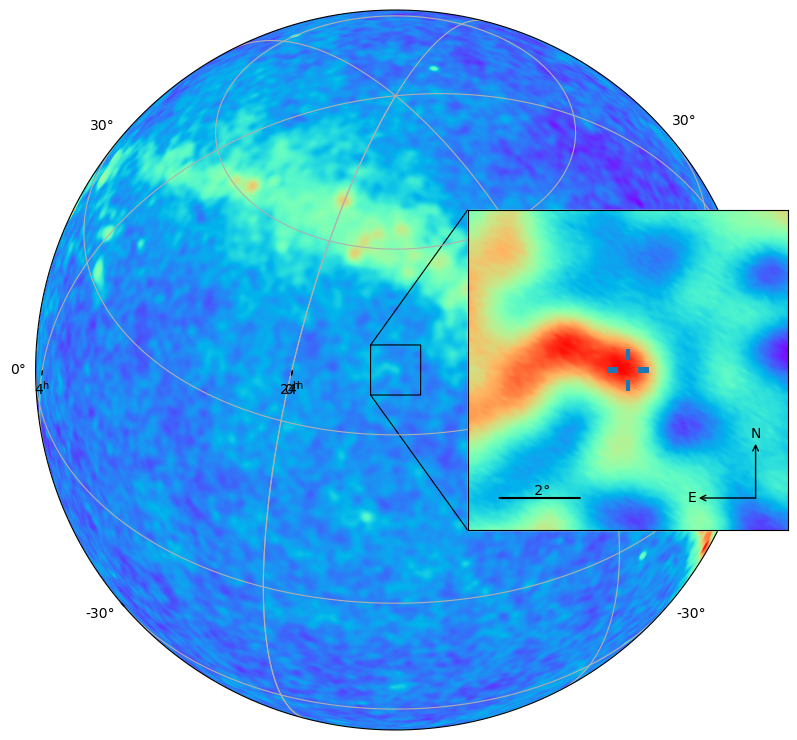

In [41]:
%matplotlib inline

skyview(fmap,c,tofile='temp.jpg')

### Quick visual check of the uncertain cases:

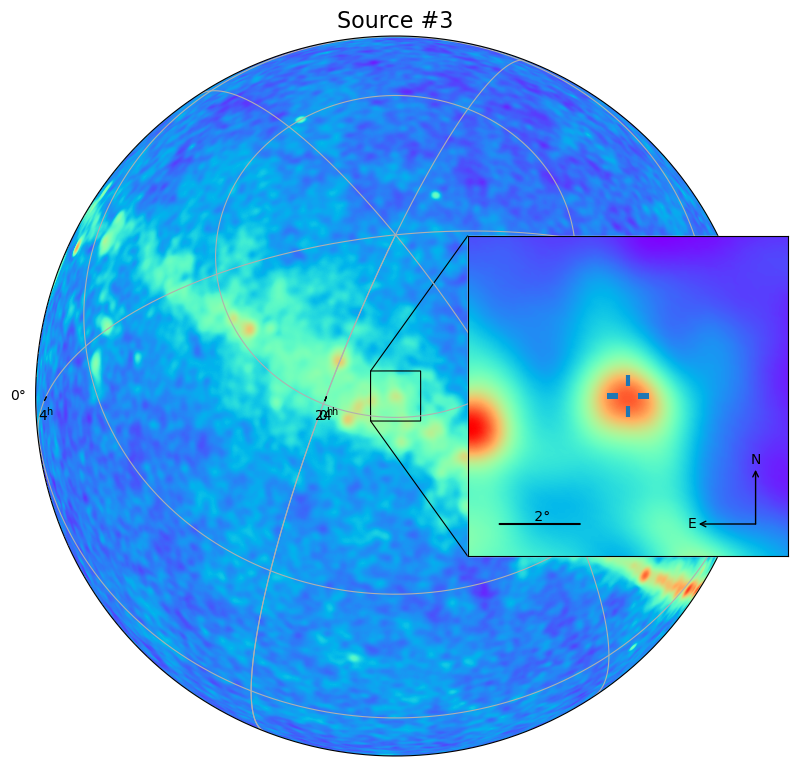

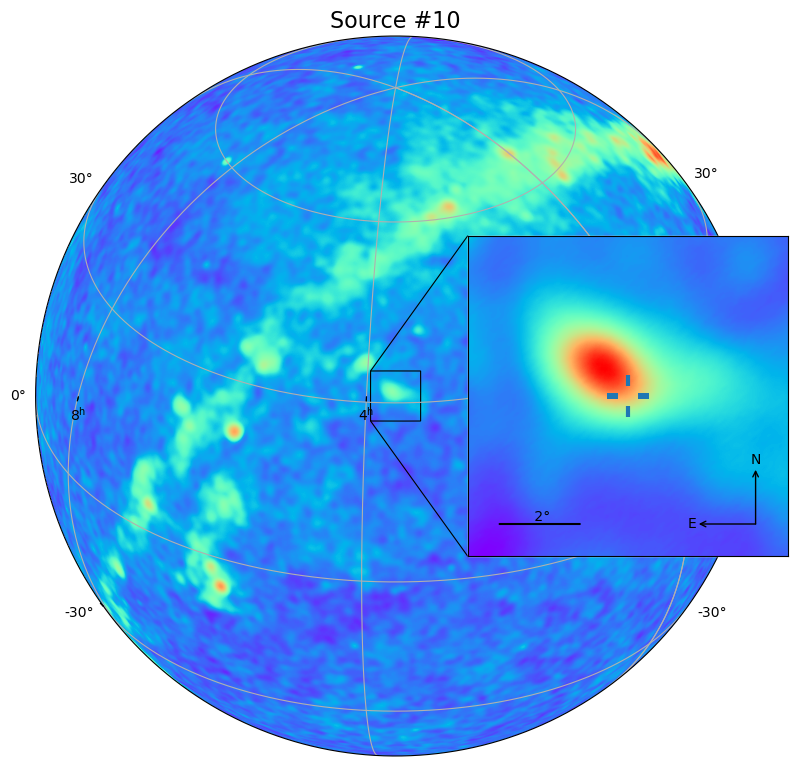

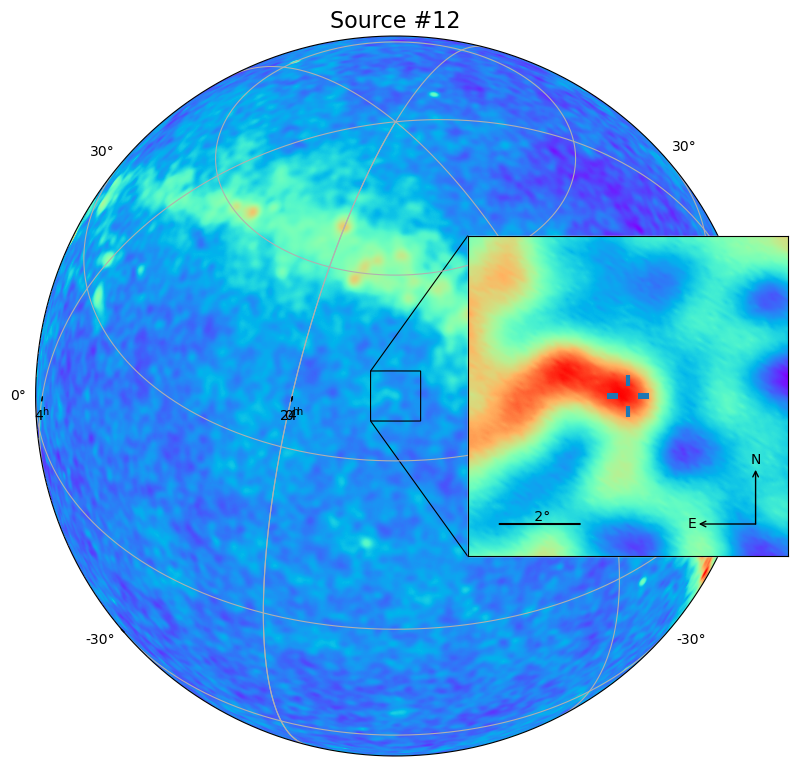

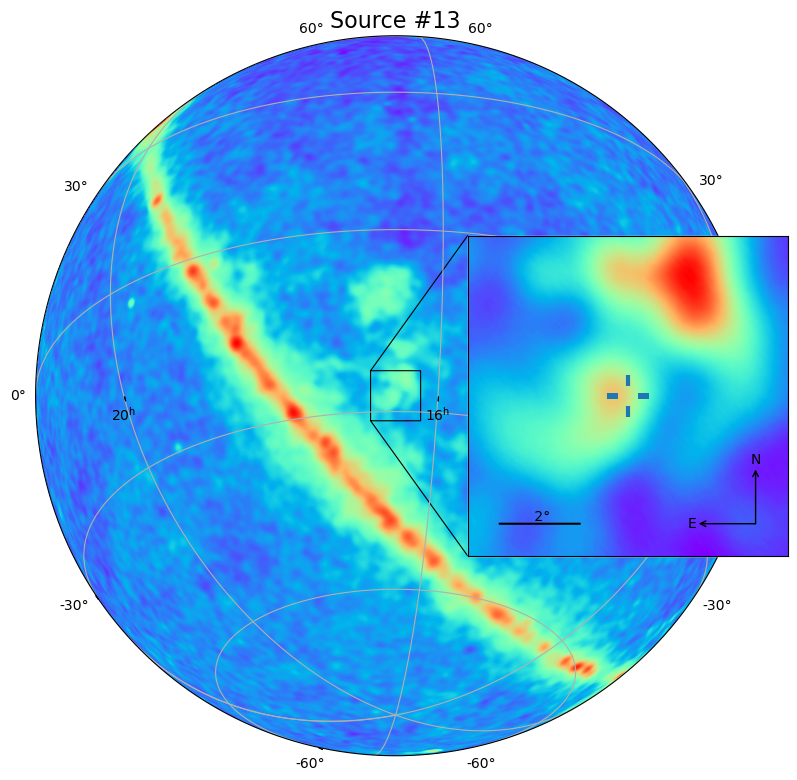

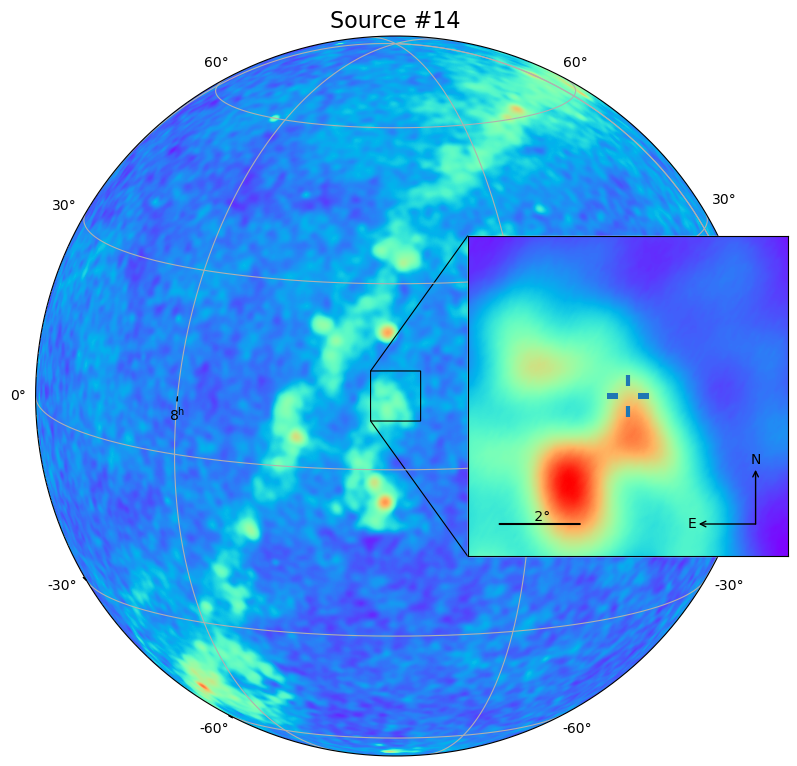

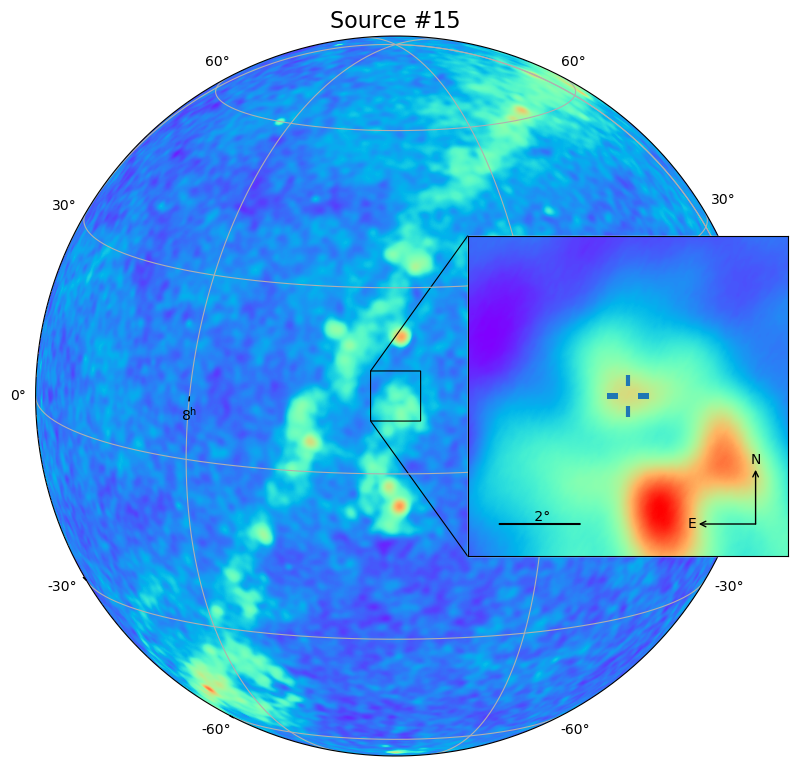

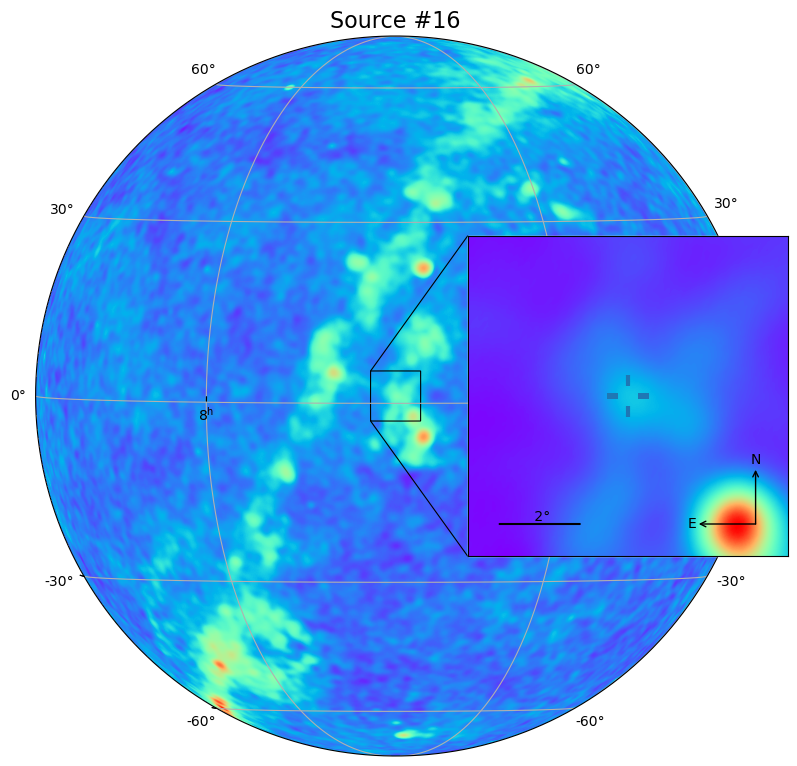

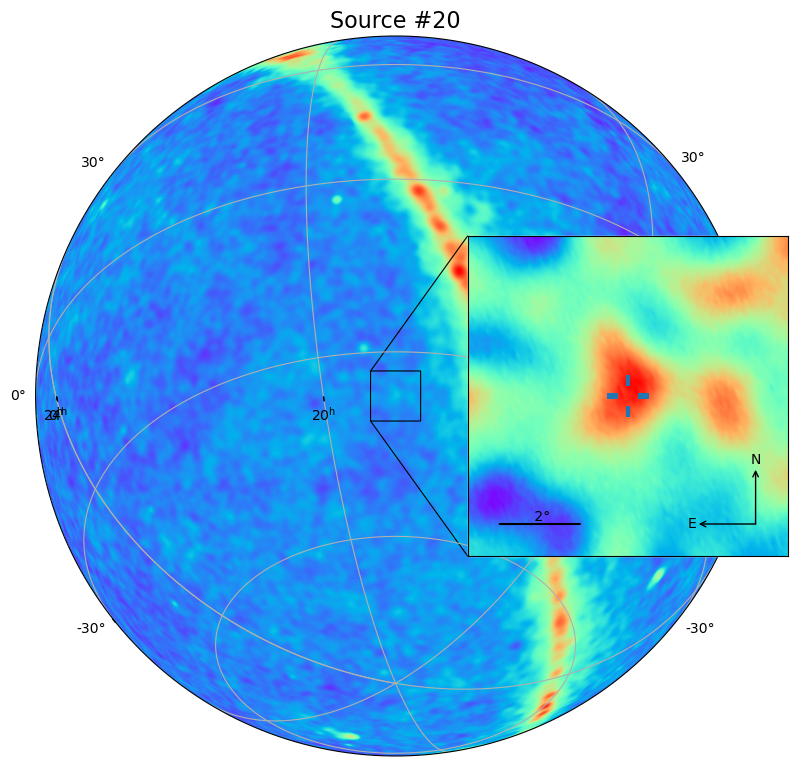

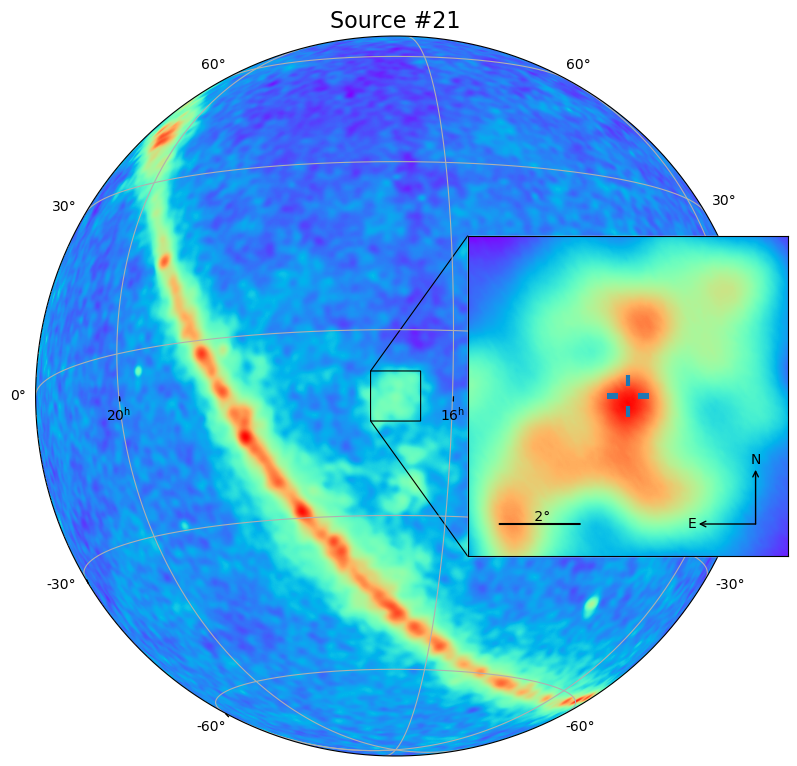

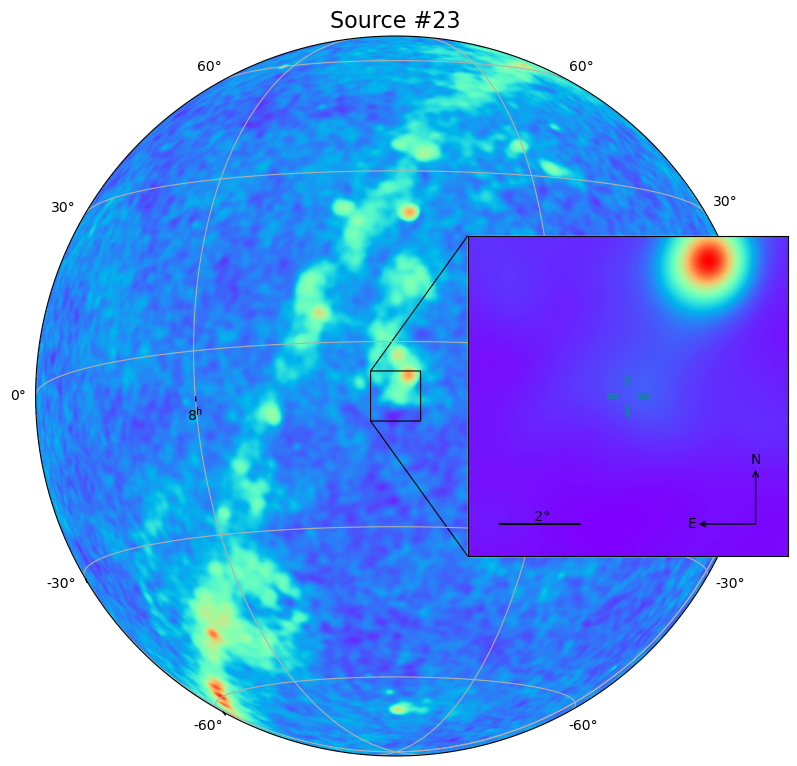

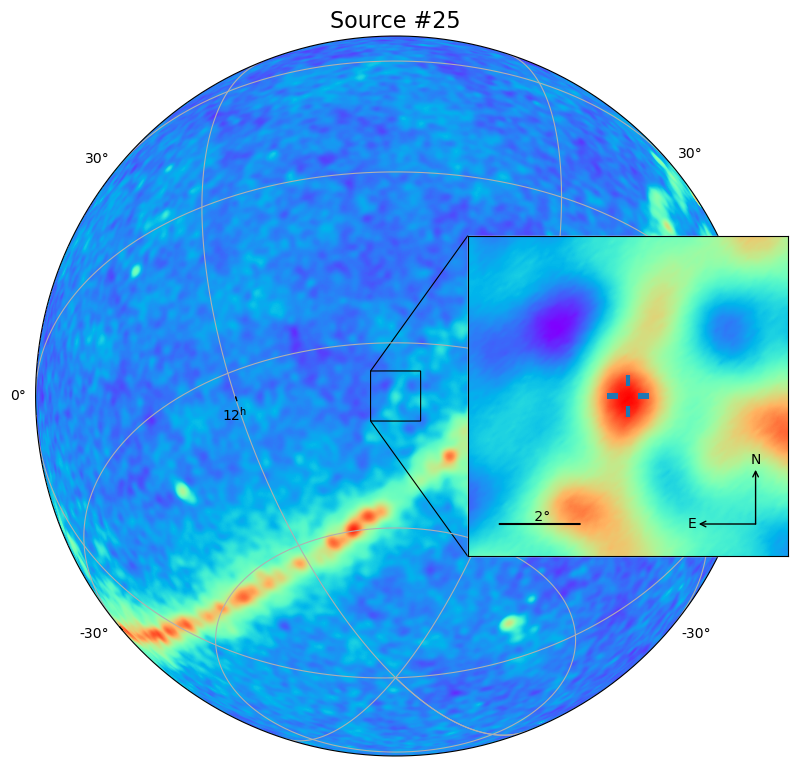

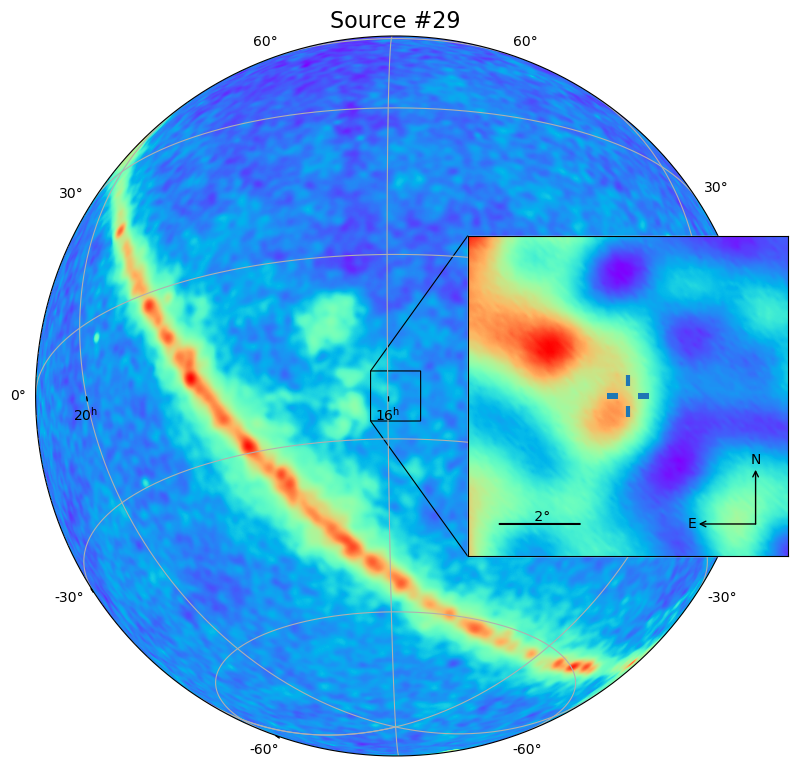

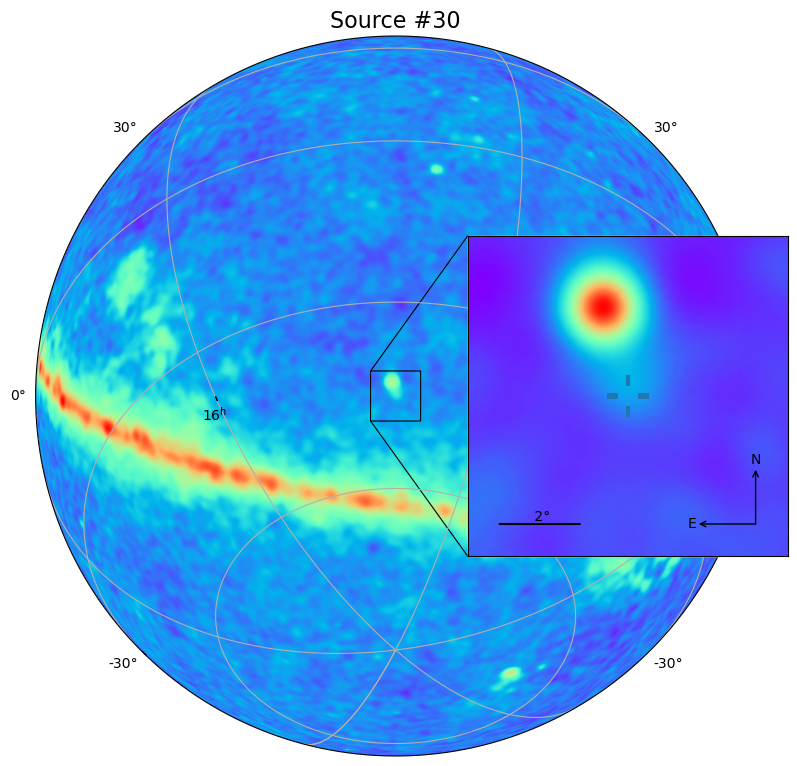

In [42]:
for ind in indexes:
    c = coords[ind-1]
    skyview(fmap,c,title='Source #{0}'.format(ind))